In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
md_path = '/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/md_one_hot_encoded_subset20.csv'
PATH = '/Users/veronica/Library/CloudStorage/GoogleDrive-veronicahangsan@gmail.com/.shortcut-targets-by-id/1FsOPywSgK_wZmrVrSTBVi4q8G3Mg_yMJ/Team-Fermata-Energy/processed_data/processed_weather_load_w_timestamp/'
json_file = '../data/subset20_20_data.json'

In [3]:
md = pd.read_csv(md_path)
with open(json_file, 'r') as file:
    json_data = json.load(file)

In [4]:
md.head

<bound method NDFrame.head of       bldg_id  in.state  in.vintage   in.sqft  \
0      105885        10           3  750000.0   
1      305819        40           2  150000.0   
2      305934        40           4  350000.0   
3      317044        40           3  350000.0   
4          32         1           6   37500.0   
...       ...       ...         ...       ...   
6396   331879        42           1   37500.0   
6397   331938        42           3   37500.0   
6398   332036        42           3    3000.0   
6399   332037        42           1   17500.0   
6400   332051        42           2   37500.0   

      in.building_america_climate_zone_Cold  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   
...                                     ...   
6396                                      0   
6397 

In [5]:
md.columns

Index(['bldg_id', 'in.state', 'in.vintage', 'in.sqft',
       'in.building_america_climate_zone_Cold',
       'in.building_america_climate_zone_Hot-Dry',
       'in.building_america_climate_zone_Hot-Humid',
       'in.building_america_climate_zone_Marine',
       'in.building_america_climate_zone_Mixed-Dry',
       'in.building_america_climate_zone_Mixed-Humid',
       'in.building_america_climate_zone_Subarctic',
       'in.building_america_climate_zone_Very Cold', 'in.iso_rto_region_CAISO',
       'in.iso_rto_region_ERCOT', 'in.iso_rto_region_MISO',
       'in.iso_rto_region_NEISO', 'in.iso_rto_region_NYISO',
       'in.iso_rto_region_PJM', 'in.iso_rto_region_SPP',
       'in.iso_rto_region_none', 'in.heating_fuel_DistrictHeating',
       'in.heating_fuel_Electricity', 'in.heating_fuel_FuelOil',
       'in.heating_fuel_NaturalGas', 'in.heating_fuel_Propane',
       'in.interior_lighting_generation_gen1_t12_incandescent',
       'in.interior_lighting_generation_gen2_t8_halogen',
     

In [6]:
train_bldg_ids = [filename.split('.')[0] for filename in json_data.get("train_bldg_ids", [])]
test_bldg_ids = [filename.split('.')[0] for filename in json_data.get("test_bldg_ids", [])]

In [7]:
md['bldg_id'] = md['bldg_id'].astype(str).str.strip()

In [8]:
education_buildings = md[md['in.comstock_building_type_group_Education'] == 1]
hot_dry_buildings = md[md['in.building_america_climate_zone_Mixed-Humid'] == 1]
edu_and_mixed_humid = education_buildings.merge(hot_dry_buildings, on='bldg_id', how='inner')
edu_and_mixed_humid_bldg_ids = edu_and_mixed_humid['bldg_id'].unique()

In [9]:
print(f"Buildings categorized as Education and in 'Hot-Dry' zone: {edu_and_mixed_humid_bldg_ids[:10]}")

Buildings categorized as Education and in 'Hot-Dry' zone: ['1025' '3050' '3587' '12020' '13244' '68162' '95419' '97705' '97898'
 '99553']


In [10]:
valid_train_bldgs = set(train_bldg_ids).intersection(edu_and_mixed_humid_bldg_ids)
valid_test_bldgs = set(test_bldg_ids).intersection(edu_and_mixed_humid_bldg_ids)

print(f"Valid train buildings (Education + Mixed-Humid): {valid_train_bldgs}")
print(f"Valid test buildings (Education + Mixed-Humid): {valid_test_bldgs}")

Valid train buildings (Education + Mixed-Humid): {'175665', '146220', '175521', '13244', '286832', '195927', '193183', '112004', '97705', '191781', '99553', '216573', '200025', '290293', '232165', '196938', '100131', '68162', '329909', '233818', '235879', '131132', '178999', '200843', '132028', '147211', '104791', '100509', '132936', '229930', '256321', '282426', '183918', '330851'}
Valid test buildings (Education + Mixed-Humid): {'232007', '145992', '235592', '230142', '146249', '235893', '100477', '1025', '177762', '177369'}


In [11]:
print(f"Number of valid training buildings: {len(valid_train_bldgs)}")
print(f"Number of valid testing buildings: {len(valid_test_bldgs)}")

Number of valid training buildings: 34
Number of valid testing buildings: 10


In [12]:
def load_data_for_building(filename, directory):
    try:
        file_path = f"{directory}/{filename}.csv"
        df = pd.read_csv(file_path)
        return df
    except Exception as e:
        print(f"Error loading file {filename}: {e}")
        return None


In [13]:
def prepare_data_for_building(df_load, md):
    """
    Prepare features (X) and target (y) for training the model.
    """
    df_load['bldg_id'] = df_load['bldg_id'].astype(str)
    md['bldg_id'] = md['bldg_id'].astype(str)

    # Create lag features
    for i in range(1, 97):
        df_load[f"shift_{i}"] = df_load["out.electricity.total.energy_consumption"].shift(i)

    # Process timestamp if available
    if 'timestamp' in df_load.columns:
        df_load['timestamp'] = pd.to_datetime(df_load['timestamp'])
        datetime_columns = {
            'hour': df_load['timestamp'].dt.hour,
            'day_of_week': df_load['timestamp'].dt.dayofweek,
            'day_of_year': df_load['timestamp'].dt.dayofyear,
            'month': df_load['timestamp'].dt.month,
            'year': df_load['timestamp'].dt.year
        }
        df_load = pd.concat([df_load, pd.DataFrame(datetime_columns)], axis=1)
        df_load = df_load.drop(columns=['timestamp'])  # drop timestamp column

    # Merge with metadata
    merged_df = df_load.merge(md, on='bldg_id', how='left')
    merged_df = merged_df.drop(['bldg_id'], axis=1)

    # Drop rows with missing values
    merged_df = merged_df.dropna()
    
    return merged_df


In [14]:
def smape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    denominator = np.abs(actual) + np.abs(predicted)
    diff = np.abs(actual - predicted) / denominator
    diff[denominator == 0] = 0.0
    return 200 * np.mean(diff)

In [15]:
def train_random_forest_model(directory, valid_train_bldgs, valid_test_bldgs, target_column='out.electricity.total.energy_consumption'):
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    from sklearn.ensemble import VotingRegressor

    rf_model = RandomForestRegressor(n_estimators=15, max_depth=4, min_samples_split=15, min_samples_leaf=10, random_state=42, n_jobs=1)
    gb_model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
    ensemble_model = VotingRegressor(estimators=[('rf', rf_model), ('gb', gb_model)])

    smape_train_list = []
    smape_test_list = []

    for building_id in valid_train_bldgs:
        train_df = load_data_for_building(building_id, directory)
        if train_df is not None and target_column in train_df:
            train_df_prepared = prepare_data_for_building(train_df, md)
            if train_df_prepared is not None and len(train_df_prepared) > 0:
                X_train = train_df_prepared.drop(columns=[target_column])
                y_train = train_df_prepared[target_column]
                ensemble_model.fit(X_train, y_train)

                y_train_pred = ensemble_model.predict(X_train)
                smape_train = smape(y_train, y_train_pred)
                smape_train_list.append(smape_train)
            else:
                print(f"Prepared data is empty for {building_id}")

    for building_id in valid_test_bldgs:
        test_df = load_data_for_building(building_id, directory)
        if test_df is not None and target_column in test_df:
            test_df_prepared = prepare_data_for_building(test_df, md)
            if test_df_prepared is not None and len(test_df_prepared) > 0:
                X_test = test_df_prepared.drop(columns=[target_column])
                y_test = test_df_prepared[target_column]
                y_test_pred = ensemble_model.predict(X_test)
                smape_test = smape(y_test, y_test_pred)
                smape_test_list.append(smape_test)

    avg_smape_train = np.mean(smape_train_list)
    avg_smape_test = np.mean(smape_test_list)
    print(f"Average SMAPE (training set): {avg_smape_train:.4f}")
    print(f"Average SMAPE (testing set): {avg_smape_test:.4f}")
    return ensemble_model


In [16]:
trained_model = train_random_forest_model(PATH, valid_train_bldgs, valid_test_bldgs)

Average SMAPE (training set): 12.4089
Average SMAPE (testing set): 31.0205


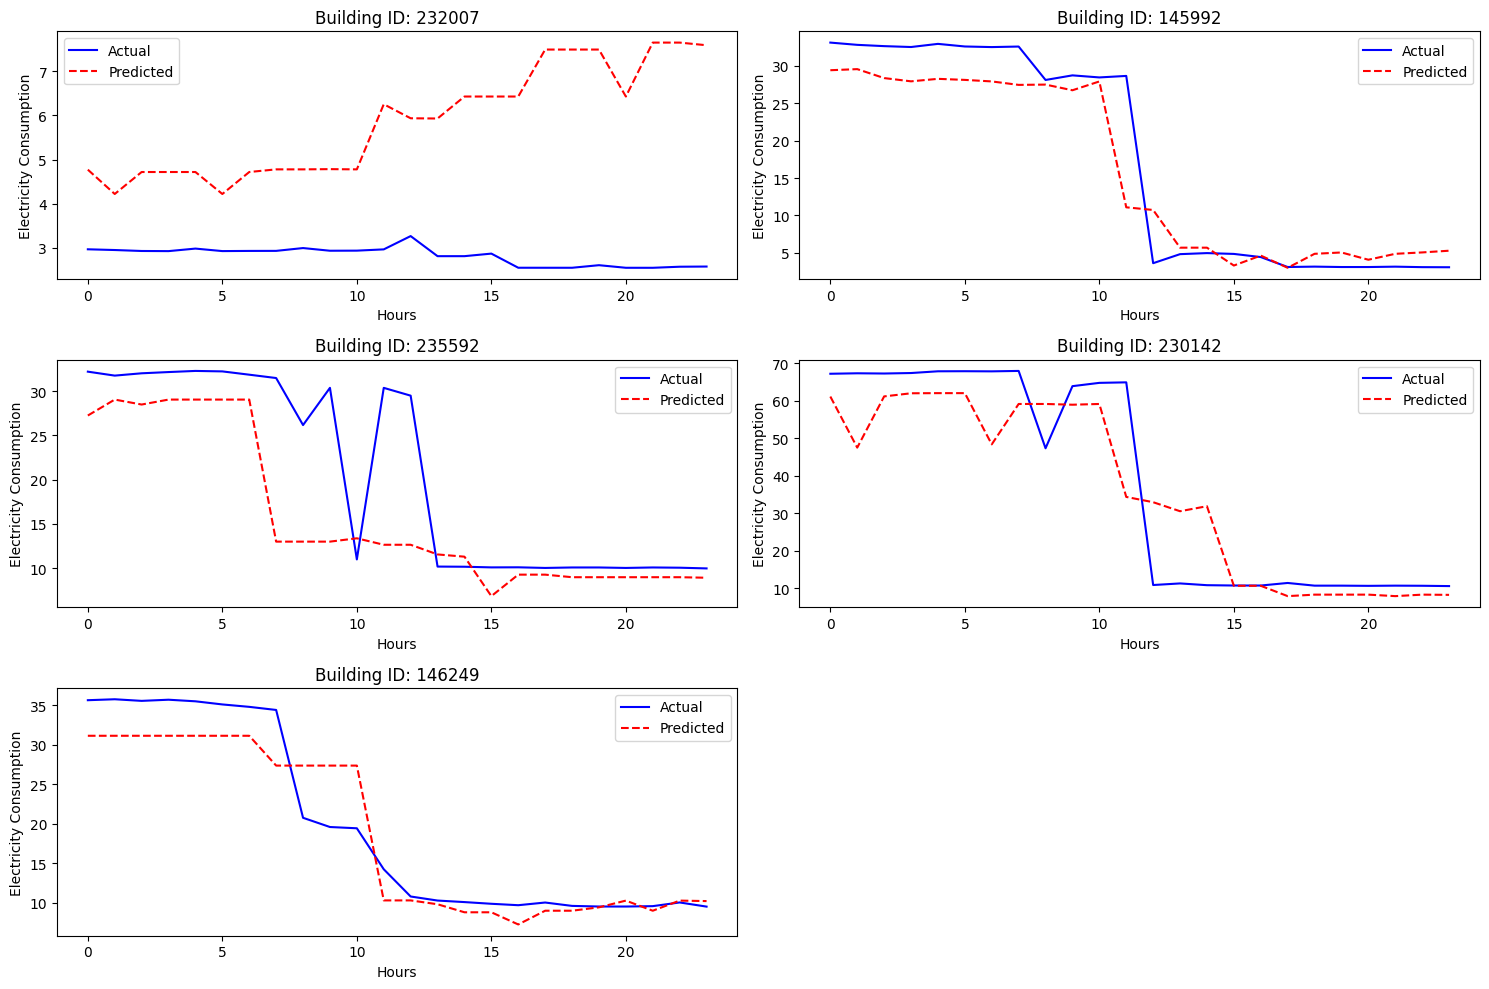

In [17]:
def plot_24_hour_predictions(building_ids, directory, model, target_column='out.electricity.total.energy_consumption'):
    plt.figure(figsize=(15, 10))
    
    for i, building_id in enumerate(building_ids[:5]):
        df = load_data_for_building(building_id, directory)
        if df is not None:
            df_prepared = prepare_data_for_building(df, md)
            
            if df_prepared is not None and len(df_prepared) > 24:
                X = df_prepared.drop(columns=[target_column])
                y_actual = df_prepared[target_column]
                y_pred = model.predict(X)
                
                # get the last 24 hours
                y_actual_24 = y_actual[-24:]
                y_pred_24 = y_pred[-24:]
                timestamps = np.arange(len(y_actual_24))
                
                plt.subplot(3, 2, i + 1)
                plt.plot(timestamps, y_actual_24, label='Actual', color='blue')
                plt.plot(timestamps, y_pred_24, label='Predicted', color='red', linestyle="--")
                plt.title(f'Building ID: {building_id}')
                plt.xlabel('Hours')
                plt.ylabel('Electricity Consumption')
                plt.legend()

    plt.tight_layout()
    plt.show()

plot_24_hour_predictions(list(valid_test_bldgs), PATH, trained_model)
